In [22]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [2]:
path1 = 'https://disk.yandex.ru/d/Lj5WClBbCt3fyw'
path2 = 'https://disk.yandex.ru/d/Vnlvg9uOrMVKhw'

In [4]:
# подготовка ссылок для загрузки в датафреймы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Получаем загрузочную ссылку
final_url1 = base_url + urlencode(dict(public_key=path1))
response = requests.get(final_url1)
download_url1 = response.json()['href']
# Получаем загрузочную ссылку
final_url2 = base_url + urlencode(dict(public_key=path2))
response = requests.get(final_url2)
download_url2 = response.json()['href']

In [5]:
df_1 = pd.read_csv(download_url1)
df_2 = pd.read_csv(download_url2)

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:
Выберите метод, который предположительно подойдет в первом вопросе.
Проверьте, являются ли дисперсии внутри групп гомогенными.
Проведите тест на нормальность распределения.
Сравните средние в представленных группах.
Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
Примите решение: какие картинки в итоге будем использовать?
Выберите метод для второго теста.
Визуализируйте распределение events для контрольной и тестовой групп. 
Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
- 11.Выберите формулу для модели, проведите тест.
Описание данных
5_task_1:

id – id клиента в эксперименте
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
events – сколько блюд суммарно было заказано за период
5_task_2:

id – id клиента в эксперименте
segment – сегмент (high/low)
group – вид кнопки (control – старая версия, test – новая версия)
events – сколько блюд суммарно было заказано за период

In [12]:
df_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [8]:
# проверяем на равномерность выборок
df_1.group.value_counts()

C    10000
A    10000
B    10000
Name: group, dtype: int64

In [10]:
# задаем группы
A = df_1.query('group=="A"').events
B = df_1.query('group=="B"').events
C = df_1.query('group=="C"').events

In [11]:
# проверяем гомогенность с помощью теста Левена
# p>0.05 дисперсии гомогенны
scipy.stats.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [14]:
# проводим семплирование тестовых выборок
A_sample = df_1[df_1['group'] == 'A']['events'].sample(1000, random_state=17)
B_sample = df_1[df_1['group'] == 'B']['events'].sample(1000, random_state=17)
C_sample = df_1[df_1['group'] == 'C']['events'].sample(1000, random_state=17)

In [15]:
# тест Шапиро-Уилка: нормально ли распределение тестовой выборки A
# при p>0.05 - распределение считаем нормальным
scipy.stats.shapiro(A_sample)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [16]:
# тест Шапиро-Уилка: нормально ли распределение тестовой выборки B
# при p>0.05 - распределение считаем нормальным
scipy.stats.shapiro(B_sample)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [17]:
# тест Шапиро-Уилка: нормально ли распределение тестовой выборки C
# при p>0.05 - распределение считаем нормальным
scipy.stats.shapiro(C_sample)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

In [20]:
scipy.stats.shapiro(C)

ShapiroResult(statistic=0.9989210963249207, pvalue=3.3885160064528463e-06)

In [21]:
# Сначала проверим однофакторным дисперсионным анализом на наличии статзначимых различий
scipy.stats.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [23]:
# с помощью pingouin и критерия Тьюки определим группы с статзначимыми различиями
# p-tukey < 0.05
pg.pairwise_tukey(data=df_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


Вторая часть задания

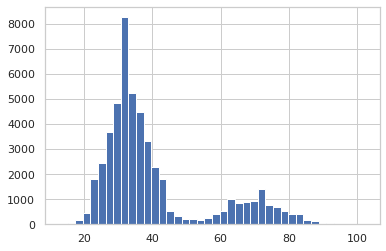

In [29]:
# распределение для тестовой группы
df_2.query('group=="test"').events.hist(bins=40)

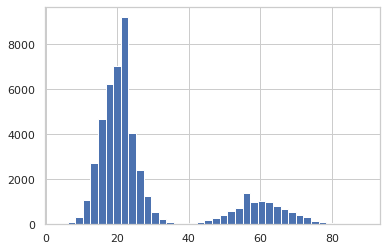

In [30]:
# распределение для контрольной группы
df_2.query('group=="control"').events.hist(bins=40)

In [44]:
df_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [49]:
# рассчитываем стандартное отклонение для сегментов в контрольной группе
df_2.query('group=="control"') \
    .groupby('segment', as_index=False) \
    .agg({"events": 'std'}) \
    .round(2)

,segment,events
0,high,7.81
1,low,4.47


In [52]:
# Делаем многофакторный дисперсионный анализ.
# задаем модель через statsmodels
model = smf.ols(formula = 'events ~ segment + group + segment:group', data = df_2).fit()
anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [56]:
# создаем колонку с комбинациями (группа и сегмент)
df_2['combination'] = df_2['group'] + ' \\ ' + df_2['segment']

In [61]:
# Методом Тьюки смотрим статзначимые пары
pairwise_tukeyhsd(df_2.events, df_2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


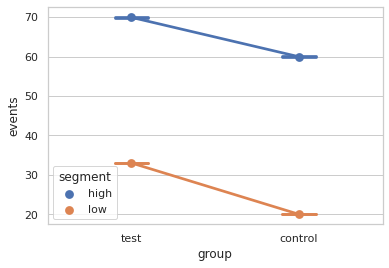

In [79]:
# визуализируем значения дисперсионного анализа
sns.pointplot(x="group", y="events", hue="segment", data=df_2, capsize=0.2)